In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
print(os.path.abspath(os.curdir))

/home/gridsan/glcf411/sigsep_mlsp


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pickle
from tqdm import tqdm

import rfcutils.qpsk_helper_fn as qpskfn
import rfcutils.ofdm_helper_fn as ofdmfn

get_pow = lambda s: np.mean(np.abs(s)**2)
get_sinr = lambda s, i: 10*np.log10(get_pow(s)/get_pow(i))

In [3]:
from src import unet_model as unet

---

In [4]:
import tensorflow as tf

In [5]:
sig_len = 1280

In [6]:
all_nn_models = []
for long_k_sz in [101, 11, 3]:
    nn_model = unet.get_unet_model0((sig_len, 2), k_sz=3, long_k_sz=long_k_sz, k_neurons=32)
    nn_model.load_weights(f'models/unet_comm_models/QPSK_OFDM_1280_K{long_k_sz}/checkpoint')
    all_nn_models.append(nn_model)
    
for long_k_sz in [101, 11, 3]:
    nn_model = unet.get_unet_model0((sig_len, 2), k_sz=3, long_k_sz=long_k_sz, k_neurons=32)
    nn_model.load_weights(f'models/unet_comm_models/SRRCGaussian_OFDMGaussian_1280_K{long_k_sz}/checkpoint')
    all_nn_models.append(nn_model)

In [7]:
cov_true_srrc, cov_ofdm_sync = pickle.load(open('stats/comm_oracle_covariance.pickle','rb'))

cov_s, cov_b = np.zeros((sig_len, sig_len), dtype=complex), np.zeros((sig_len, sig_len), dtype=complex)
for i in range(80):
    cov_s += cov_true_srrc[i:i+sig_len, i:i+sig_len]
    cov_b += cov_ofdm_sync[i:i+sig_len, i:i+sig_len]
cov_s = cov_s / 80
cov_b = cov_b / 80

In [8]:
from scipy import linalg

window_len = 1280
def lmmse(sig_mixture, sinr_db):
    sinr = 10**(sinr_db/10)
    
    scaled_Cbb = cov_b * 1/sinr
    Cyy = cov_s + scaled_Cbb + 0.01*np.eye(window_len, dtype=complex)
    Csy = cov_s.copy()

#     Cyy_inv = np.linalg.pinv(Cyy,hermitian=True)
    U,S,Vh = np.linalg.svd(Cyy,hermitian=True)
    sthr_idx = np.linalg.matrix_rank(Cyy) + 1
    Cyy_inv = np.matmul(U[:,:sthr_idx], np.matmul(np.diag(1.0/(S[:sthr_idx])), U[:,:sthr_idx].conj().T))
    W = np.matmul(Csy,Cyy_inv)
    
    s_est_windows = np.matmul(W, sig_mixture.reshape(-1, window_len).T).T
    s_est = s_est_windows.flatten()
    
    return s_est

def sync_mmse(sig_mixture, sinr_db, tau_b, tau_s):
    Css = cov_true_srrc[tau_s:tau_s+window_len, tau_s:tau_s+window_len]
    Cbb = cov_ofdm_sync[tau_b:tau_b+window_len, tau_b:tau_b+window_len]
    
    sinr = 10**(sinr_db/10)
    scaled_Cbb = Cbb * 1/sinr
    Cyy = Css + scaled_Cbb + 0.01*np.eye(window_len, dtype=complex)
    Csy = Css.copy()
    
    U,S,Vh = np.linalg.svd(Cyy,hermitian=True)
    sthr_idx = np.linalg.matrix_rank(Cyy) + 1
    Cyy_inv = np.matmul(U[:,:sthr_idx], np.matmul(np.diag(1.0/(S[:sthr_idx])), U[:,:sthr_idx].conj().T))
    W = np.matmul(Csy,Cyy_inv)
    
    s_est_windows = np.matmul(W, sig_mixture.reshape(-1, window_len).T).T
    s_est = s_est_windows.flatten()
    
    err = Csy - np.matmul(W, Csy.conj().T)
    err = np.abs(np.mean(np.diag(Csy - np.matmul(W, Csy.conj().T))))
    return s_est, err

In [9]:
def get_ber(sig_true, sig_est, idx_offset):
    start_idx = (16 - idx_offset%16)%16
    sig_true_seg = sig_true[start_idx:]
    sig_est_seg = sig_est[start_idx:]
    bit_true = qpskfn.matched_filter_demod(sig_true_seg)
    bit_est = qpskfn.matched_filter_demod(sig_est_seg)
    assert len(bit_true) == len(bit_est)
    bit_err = np.sum(bit_true != bit_est)/len(bit_true)
    return bit_err

In [10]:
import random
random.seed(123)
np.random.seed(123)

all_components = []

all_mse = []
n_per_sinr = 1000
all_sinr_ax = np.arange(-30,4,1.5)
all_err = []

all_ber = []

for target_sinr in tqdm(all_sinr_ax):
    for idx in range(n_per_sinr):
        sig1, _, _, _ = qpskfn.generate_qpsk_signal(sig_len//16 + 80)
        start_idx0 = np.random.randint(16)
        sig1 = sig1[40*16+start_idx0:40*16+sig_len+start_idx0]

        data2, _, _ = ofdmfn.generate_ofdm_signal(sig_len//80*56+4*56)
        start_idx = np.random.randint(len(data2)-sig_len)
        sig2 = data2[start_idx:start_idx+sig_len]

        coeff = np.sqrt(np.mean(np.abs(sig1)**2)/(np.mean(np.abs(sig2)**2)*(10**(target_sinr/10))))
        
        noise = 0.1/np.sqrt(2) * (np.random.randn(sig_len) + 1j*np.random.randn(sig_len))
        sig_mixture = sig1 + sig2*coeff + noise
        
        all_components.append((sig_mixture, sig1, sig2, noise, coeff))
        
        sig1_lmmse = lmmse(sig_mixture, target_sinr)
        sig1_smmse, err = sync_mmse(sig_mixture, target_sinr, start_idx % 80, start_idx0 % 80)
        all_err.append(err)
        
        mixture_segT = sig_mixture.reshape(-1, sig_len)
        mixture_bands_compT = np.dstack((mixture_segT.real, mixture_segT.imag))
        
        with tf.device('GPU:0'):
            mse_arr, mse2_arr, ber_arr = [], [], []
            for nn_model in all_nn_models:
                out1_est = nn_model(mixture_bands_compT).numpy()
                sig1_est = (out1_est[:,:,0] + 1j*out1_est[:,:,1]).flatten()
                
                mse_arr.append(get_pow(sig1-sig1_est))
                ber_arr.append(get_ber(sig1, sig1_est, start_idx0))
        
        mse_arr.append(get_pow(sig1-sig1_lmmse))
        mse_arr.append(get_pow(sig1-sig1_smmse))
        
        ber_arr.append(get_ber(sig1, sig1_lmmse, start_idx0))
        ber_arr.append(get_ber(sig1, sig1_smmse, start_idx0))
        ber_arr.append(get_ber(sig1, sig_mixture, start_idx0))
        
        all_mse.append(mse_arr)
        all_ber.append(ber_arr)

100%|██████████| 23/23 [17:23:17<00:00, 2721.65s/it]  


In [11]:
plt.rcParams['font.size'] = '14'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.markeredgewidth'] = 2
plt.rcParams["font.family"] = "serif"

Text(0, 0.5, 'BER($s$,$\\hat{s}$)')

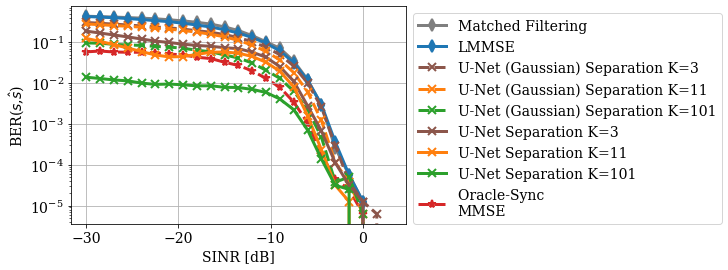

In [12]:
all_ber = np.array(all_ber)

plt.plot(all_sinr_ax, (all_ber[:,-1].reshape(-1,n_per_sinr).mean(axis=-1)), 'd-', label='Matched Filtering', color='tab:gray')
plt.plot(all_sinr_ax, (all_ber[:,-3].reshape(-1,n_per_sinr).mean(axis=-1)), 'd-', label='LMMSE', color='tab:blue')

plt.plot(all_sinr_ax, (all_ber[:,5].reshape(-1,n_per_sinr).mean(axis=-1)), 'x--', label='U-Net (Gaussian) Separation K=3', color='tab:brown')
plt.plot(all_sinr_ax, (all_ber[:,4].reshape(-1,n_per_sinr).mean(axis=-1)), 'x--', label='U-Net (Gaussian) Separation K=11', color='tab:orange')
plt.plot(all_sinr_ax, (all_ber[:,3].reshape(-1,n_per_sinr).mean(axis=-1)), 'x--', label='U-Net (Gaussian) Separation K=101', color='tab:green')

plt.plot(all_sinr_ax, (all_ber[:,2].reshape(-1,n_per_sinr).mean(axis=-1)), 'x-', label='U-Net Separation K=3', color='tab:brown')
plt.plot(all_sinr_ax, (all_ber[:,1].reshape(-1,n_per_sinr).mean(axis=-1)), 'x-', label='U-Net Separation K=11', color='tab:orange')
plt.plot(all_sinr_ax, (all_ber[:,0].reshape(-1,n_per_sinr).mean(axis=-1)), 'x-', label='U-Net Separation K=101', color='tab:green')

plt.semilogy(all_sinr_ax, (all_ber[:,-2].reshape(-1,n_per_sinr).mean(axis=-1)), '*--', label='Oracle-Sync \nMMSE', zorder=0, color='tab:red')

plt.legend(bbox_to_anchor=(1.1, 1))
# plt.xlim([-30,3])
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('SINR [dB]')
plt.ylabel('BER($s$,$\hat{s}$)')

[-16.32667973  -8.37592566  -6.59554984  -6.63786253  -4.09907668
  -3.82785069  -2.8850938   -7.66322761]


Text(0, 0.5, 'MSE($s$,$\\hat{s}$) [dB]')

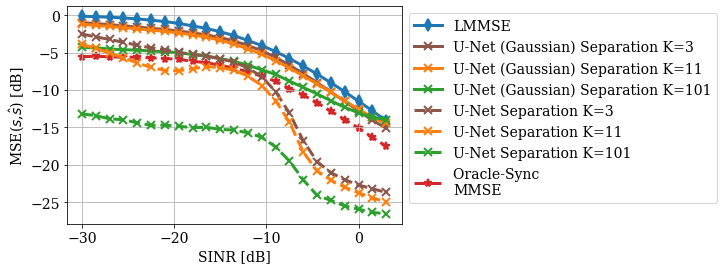

In [13]:
all_mse = np.array(all_mse)
print(10*np.log10(all_mse.mean(axis=0)))

plt.plot(all_sinr_ax, 10*np.log10(all_mse[:,-2].reshape(-1,n_per_sinr).mean(axis=-1)), 'd-', label='LMMSE')

plt.plot(all_sinr_ax, 10*np.log10(all_mse[:,5].reshape(-1,n_per_sinr).mean(axis=-1)), 'x-', label='U-Net (Gaussian) Separation K=3', color='tab:brown')
plt.plot(all_sinr_ax, 10*np.log10(all_mse[:,4].reshape(-1,n_per_sinr).mean(axis=-1)), 'x-', label='U-Net (Gaussian) Separation K=11', color='tab:orange')
plt.plot(all_sinr_ax, 10*np.log10(all_mse[:,3].reshape(-1,n_per_sinr).mean(axis=-1)), 'x-', label='U-Net (Gaussian) Separation K=101', color='tab:green')

plt.plot(all_sinr_ax, 10*np.log10(all_mse[:,2].reshape(-1,n_per_sinr).mean(axis=-1)), 'x--', label='U-Net Separation K=3', color='tab:brown')
plt.plot(all_sinr_ax, 10*np.log10(all_mse[:,1].reshape(-1,n_per_sinr).mean(axis=-1)), 'x--', label='U-Net Separation K=11', color='tab:orange')
plt.plot(all_sinr_ax, 10*np.log10(all_mse[:,0].reshape(-1,n_per_sinr).mean(axis=-1)), 'x--', label='U-Net Separation K=101', color='tab:green')

plt.plot(all_sinr_ax, 10*np.log10(all_mse[:,-1].reshape(-1,n_per_sinr).mean(axis=-1)), '*--', label='Oracle-Sync \nMMSE', zorder=0, color='tab:red')

plt.legend(bbox_to_anchor=(1.1, 1))
# plt.xlim([-30,3])
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('SINR [dB]')
plt.ylabel('MSE($s$,$\hat{s}$) [dB]')

In [15]:
method_legend = ['U-Net (Comm) K=101', 'U-Net (Comm) K=11', 'U-Net (Comm) K=3', 'U-Net (Gaussian) K=101', 'U-Net (Gaussian) K=11', 'U-Net (Gaussian) K=3', 'LMMSE', 'Oracle Sync MMSE', 'Matched Filtering (for BER)']
pickle.dump((all_mse, all_ber, method_legend), open('output/EXTRA_QPSKComm_Outputs.pickle', 'wb'))